In [1]:
import warnings,sys,os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import geohexgrid as ghg
import seaborn as sns
import shapely
from shapely import Point
import igraph as ig
from pathlib import Path
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
from matplotlib.colors import LinearSegmentedColormap,Normalize
from matplotlib.ticker import FuncFormatter, MultipleLocator
from matplotlib.patches import Rectangle,Patch
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
from exactextract import exact_extract
from matplotlib.lines import Line2D  # For custom legend
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as cx                                  
from simplify import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as cx
import pandas as pd
import geopandas as gpd
from matplotlib.lines import Line2D

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives a warning that is invalid

In [ ]:
BASE_DIR = Path.cwd().parent
data_path = BASE_DIR / "input_files"
figure_path = BASE_DIR / "figures"
intermediate_results_path = BASE_DIR / 'intermediate_results'

In [3]:
# =============================================================================
# 1. Load network and create graph
# =============================================================================
base_network = gpd.read_parquet(data_path / "base_network_SRB_basins.parquet")

edges = base_network.reindex(['from_id','to_id'] + [x for x in list(base_network.columns) if x not in ['from_id','to_id']], axis=1)
graph = ig.Graph.TupleList(edges.itertuples(index=False), edge_attrs=list(edges.columns)[2:], directed=True)
graph = graph.connected_components().giant()
edges = edges[edges['id'].isin(graph.es['id'])]

In [4]:
# path to the Statments populaiton file
Path_StatementFile_Excel = data_path / "population_NEW_settlement_geocoded.xlsx"

# reading the Excel file
DataFrame_StatePop = pd.read_excel(Path_StatementFile_Excel)

# to keep only rows with valid coordinates and population
Clean_DataFrame_StatePop = DataFrame_StatePop.dropna(subset=["latitude", "longitude", "Total"])

# to make point geometry
geometry = [Point(xy) for xy in zip(Clean_DataFrame_StatePop["longitude"], Clean_DataFrame_StatePop["latitude"])]

# build GeoDataFrame matching df_worldpop structure
df_worldpop = gpd.GeoDataFrame(
    Clean_DataFrame_StatePop[["Total"]].rename(columns={"Total": "population"}),
    geometry=geometry,
    crs="EPSG:4326"  # longitude/latitude WGS84
)

# gdf is equivalent in structure to your df_worldpop
print(df_worldpop.head())

    population                   geometry
15      8967.0  POINT (20.42527 44.59395)
16      2044.0  POINT (20.37528 44.58539)
17       695.0   POINT (20.3954 44.51975)
18      1146.0   POINT (20.40044 44.5645)
19      1268.0  POINT (20.35048 44.53938)


In [5]:
vertex_lookup = dict(zip(pd.DataFrame(graph.vs['name'])[0], pd.DataFrame(graph.vs['name']).index))

tqdm.pandas()
from_id_geom = edges.geometry.progress_apply(lambda x: shapely.Point(x.coords[0]))
to_id_geom = edges.geometry.progress_apply(lambda x: shapely.Point(x.coords[-1]))

from_dict = dict(zip(edges['from_id'], from_id_geom))
to_dict = dict(zip(edges['to_id'], to_id_geom))

nodes = pd.concat([pd.DataFrame.from_dict(to_dict, orient='index', columns=['geometry']),
                   pd.DataFrame.from_dict(from_dict, orient='index', columns=['geometry'])]).drop_duplicates()

nodes['vertex_id'] = nodes.progress_apply(lambda x: vertex_lookup[x.name], axis=1)
nodes = nodes.reset_index()

nodes_sindex = shapely.STRtree(nodes.geometry)

df_worldpop['vertex_id'] = df_worldpop.geometry.progress_apply(lambda x: nodes.iloc[nodes_sindex.nearest(x)].vertex_id).values

100%|██████████| 4673/4673 [00:00<00:00, 12775.04it/s]


In [6]:
Sink = pd.read_excel(
    data_path / "6_Police_geocoded.xlsx")
Sink = Sink.rename(columns={"lon": "Longitude", "lat": "Latitude"})
Sink['geometry'] = Sink.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
Sink['vertex_id'] = Sink.geometry.apply(lambda x: nodes.iloc[nodes_sindex.nearest(x)].vertex_id).values

In [7]:
def get_distance_to_nearest_facility(df_population, Sink, graph):
    """
    Optimized version using bulk distance matrix calculation with duplicate vertex_id handling
    """
    # Initialize new columns
    df_population = df_population.copy()
    df_population['closest_sink_vertex_id'] = None
    df_population['closest_sink_osm_id'] = None
    df_population['closest_sink_total_fft'] = None
    
    # Get unique vertex IDs for both population and sinks
    unique_pop_vertex_ids = df_population['vertex_id'].unique()
    unique_sink_vertex_ids = Sink['vertex_id'].unique()
    
    # Create mapping from unique sink vertex_ids back to original sink data
    sink_lookup = {}
    for _, row in Sink.iterrows():
        sink_lookup[row['vertex_id']] = row['i.d.']
    
    # Calculate distance matrix once for unique vertices only
    distance_matrix = np.array(graph.distances(
        source=unique_pop_vertex_ids,
        target=unique_sink_vertex_ids, 
        weights='fft'
    ))
    
    # Create lookup dictionary: vertex_id -> (closest_sink_vertex_id, closest_sink_osm_id, min_distance)
    vertex_to_closest_sink = {}
    
    for i, pop_vertex_id in enumerate(unique_pop_vertex_ids):
        # Get distances from this population point to all unique sinks
        distances_to_sinks = distance_matrix[i, :]
        
        # Find the index of the minimum distance
        min_sink_idx = np.argmin(distances_to_sinks)
        min_distance = distances_to_sinks[min_sink_idx]
        
        # Handle infinite distances (no path found)
        if np.isinf(min_distance):
            vertex_to_closest_sink[pop_vertex_id] = (None, None, float('inf'))
        else:
            closest_sink_vertex_id = unique_sink_vertex_ids[min_sink_idx]
            closest_sink_osm_id = sink_lookup[closest_sink_vertex_id]
            vertex_to_closest_sink[pop_vertex_id] = (
                closest_sink_vertex_id,
                closest_sink_osm_id, 
                min_distance
            )
    
    # Map results back to all population points (including duplicates)
    for idx, row in df_population.iterrows():
        vertex_id = row['vertex_id']
        closest_sink_vertex_id, closest_sink_osm_id, closest_sink_total_fft = vertex_to_closest_sink[vertex_id]
        
        df_population.at[idx, 'closest_sink_vertex_id'] = closest_sink_vertex_id
        df_population.at[idx, 'closest_sink_osm_id'] = closest_sink_osm_id
        df_population.at[idx, 'closest_sink_total_fft'] = closest_sink_total_fft
    
    return df_population

In [8]:
%%time
df_worldpop = get_distance_to_nearest_facility(df_worldpop,Sink,graph)

CPU times: total: 6min 32s
Wall time: 6min 45s


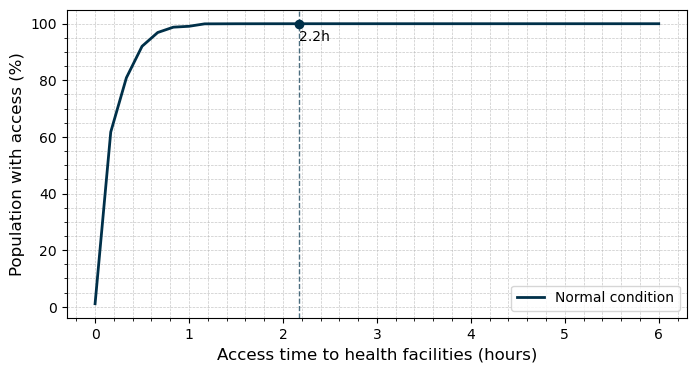

In [ ]:
fig, ax_curve = plt.subplots(1, 1, figsize=(8, 4))


# Panel B: Calculate access curves
None_INF_Pop_in_Zone_Sample = df_worldpop.copy()
total_population = df_worldpop['population'].sum()
thresholds = np.arange(0, 6.1, 1/6)  

percentage_population_within_threshold_2 = []


for threshold in thresholds:
    population_sum_2 = df_worldpop.loc[
        df_worldpop['closest_sink_total_fft'] <= threshold, 'population'
    ].sum()
    population_percentage_2 = (population_sum_2 / total_population) * 100
    percentage_population_within_threshold_2.append(population_percentage_2)

# Find 100% thresholds
threshold_100_2 = next((threshold for i, threshold in enumerate(thresholds) 
                       if percentage_population_within_threshold_2[i] == 100), None)

# Plot access curves
ax_curve.plot(thresholds, percentage_population_within_threshold_2, linestyle='-', 
             color='#003049', linewidth=2, label='Normal condition')

ax_curve.set_xlabel('Access time to health facilities (hours)', fontsize=12)
ax_curve.set_ylabel('Population with access (%)', fontsize=12)
ax_curve.legend(fontsize=10)
ax_curve.minorticks_on()
ax_curve.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Match Panel A's height by setting aspect ratio
ax_curve.set_aspect('auto', adjustable='box')

if threshold_100_2 is not None:
    ax_curve.axvline(x=threshold_100_2, color='#003049', linestyle='--', linewidth=1, alpha=0.7)
    ax_curve.plot(threshold_100_2, 100, 'o', color='#003049', markersize=6)
    ax_curve.text(threshold_100_2, 94, f'{threshold_100_2:.1f}h', color='black', ha='left', fontsize=10)

plt.savefig(figure_path / 'baseline_accessibility_police_disruptions.png',dpi=150,transparent=True)

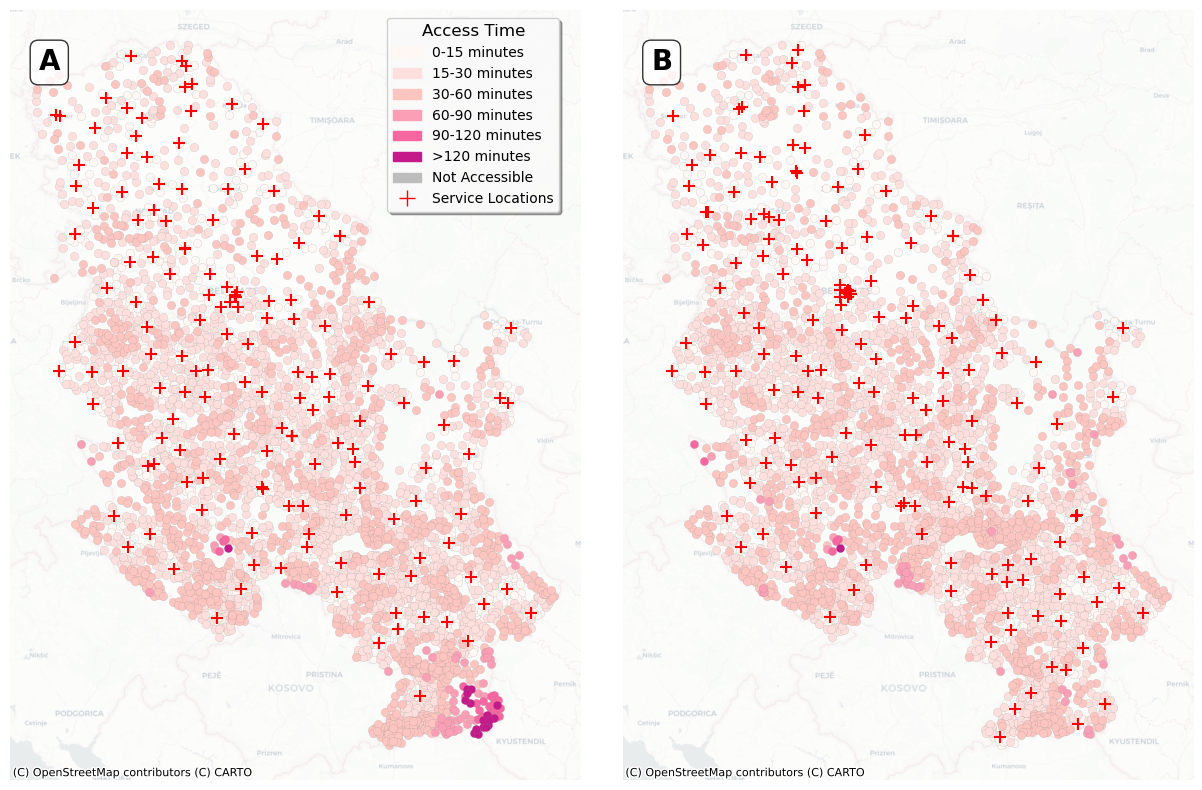

In [ ]:
# Load data
df_worldpop_fire = gpd.read_parquet(intermediate_results_path / 'firefighter_settle_results.parquet')
Sink_fire = gpd.read_parquet(intermediate_results_path / 'firefighters.parquet')

df_worldpop_fire = gpd.GeoDataFrame(df_worldpop_fire, geometry='geometry', crs="EPSG:4326").to_crs(3857)
Sink_fire = gpd.GeoDataFrame(Sink_fire, geometry='geometry', crs="EPSG:4326").to_crs(3857)

df_worldpop_police = gpd.GeoDataFrame(df_worldpop, geometry='geometry', crs="EPSG:4326").to_crs(3857)
Sink_police = gpd.GeoDataFrame(Sink, geometry='geometry', crs="EPSG:4326").to_crs(3857)

# Define bins, labels, and colors (shared)
bins = [0, 0.25, 0.5, 1, 1.5, 2, float('inf')]
labels = ['0-15', '15-30', '30-60', '60-90', '90-120', '>120']
colors = ['#fff7f3', '#fde0dd', '#fcc5c0', '#fa9fb5', '#f768a1', '#c51b8a']
color_map = dict(zip(labels, colors))
color_map['Not Accessible'] = '#bdbdbd'

# Prepare datasets
datasets = {
    'A': ('Fire Departments', df_worldpop_fire, Sink_fire, 'Fire Departments'),
    'B': ('Police Stations', df_worldpop_police, Sink_police, 'Police Stations')
}

# Create figure with 1 row x 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 8), facecolor='white')

for idx, (letter, (title, df_worldpop_to_use, Sink_to_plot, sink_label)) in enumerate(datasets.items()):
    ax = axes[idx]
    
    # Prepare data
    df_worldpop_plot = df_worldpop_to_use.copy() #gpd.GeoDataFrame(df_worldpop, geometry='geometry', crs="EPSG:4326").to_crs(3857)
    Sink_plot = Sink_to_plot.copy()#gpd.GeoDataFrame(Sink, geometry='geometry', crs="EPSG:4326").to_crs(3857)
    
    # Assign categories
    df_worldpop_plot['category'] = pd.cut(df_worldpop_plot['closest_sink_total_fft'], 
                                           bins=bins, labels=labels, right=False)
    df_worldpop_plot['category'] = df_worldpop_plot['category'].astype('object')
    df_worldpop_plot.loc[df_worldpop_plot['category'].isna(), 'category'] = 'Not Accessible'
    
    # Plot by category
    for category, color in color_map.items():
        data = df_worldpop_plot[df_worldpop_plot['category'] == category]
        if not data.empty:
            data.plot(ax=ax, color=color, legend=False, linewidth=0.1, edgecolor='grey')
    
    # Plot sink locations
    Sink_plot.plot(ax=ax, color='red', markersize=80, marker='+', zorder=5)
    
    # Add basemap
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, alpha=0.5)
    
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add letter label
    ax.text(0.05, 0.95, letter, transform=ax.transAxes, fontsize=20, 
            fontweight='bold', verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Create shared legend
legend_patches = [mpatches.Patch(color=color, label=f'{label} minutes') 
                  for label, color in zip(labels, colors)]
legend_patches.append(mpatches.Patch(color='#bdbdbd', label='Not Accessible'))
legend_patches.append(Line2D([0], [0], marker='+', color='red', lw=0, 
                             label='Service Locations', markersize=12))

fig.legend(handles=legend_patches, 
           loc='center right',
           bbox_to_anchor=(0.43, 0.85),
           fontsize=10,
           title='Access Time',
           title_fontsize=12,
           frameon=True,
           fancybox=True,
           shadow=True,
           framealpha=0.95,
           facecolor='white',
           edgecolor='#cccccc')

plt.tight_layout()
plt.subplots_adjust(right=0.90)  # Make room for shared legend
plt.savefig(figure_path / 'emergency_services_access.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
import pandas as pd
import numpy as np

# Define bins and labels
bins = [0, 0.25, 0.5, 1, 1.5, 2, float('inf')]
labels = ['0-15', '15-30', '30-60', '60-90', '90-120', '>120']

# Prepare datasets
datasets = {
    'Fire Departments': (df_worldpop_fire, Sink_fire),
    'Police Stations': (df_worldpop_police, Sink_police)
}

print("=" * 70)
print("EMERGENCY SERVICES ACCESSIBILITY ANALYSIS")
print("=" * 70)

summary_data = []

for service_name, (df_worldpop, Sink) in datasets.items():
    print(f"\n{'─' * 50}")
    print(f"{service_name.upper()}")
    print(f"{'─' * 50}")
    
    # Number of service locations
    n_facilities = len(Sink)
    print(f"\nNumber of {service_name}: {n_facilities:,}")
    
    # Number of settlements analyzed
    n_settlements = len(df_worldpop)
    print(f"Number of settlements analyzed: {n_settlements:,}")
    
    # Access time statistics (convert to minutes)
    access_time_minutes = df_worldpop['closest_sink_total_fft'] * 60
    
    print(f"\nAccess Time Statistics (minutes):")
    print(f"  Mean: {access_time_minutes.mean():.2f} minutes")
    print(f"  Median: {access_time_minutes.median():.2f} minutes")
    print(f"  Std Dev: {access_time_minutes.std():.2f} minutes")
    print(f"  Min: {access_time_minutes.min():.2f} minutes")
    print(f"  Max: {access_time_minutes.max():.2f} minutes")
    
    # Create categories
    df_worldpop['category'] = pd.cut(df_worldpop['closest_sink_total_fft'], 
                                      bins=bins, labels=labels, right=False)
    df_worldpop['category'] = df_worldpop['category'].astype('object')
    df_worldpop.loc[df_worldpop['category'].isna(), 'category'] = 'Not Accessible'
    
    # Distribution by category
    print(f"\nSettlements by Access Time Category:")
    cat_counts = df_worldpop['category'].value_counts()
    cat_order = labels + ['Not Accessible']
    for cat in cat_order:
        if cat in cat_counts.index:
            count = cat_counts[cat]
            pct = (count / n_settlements) * 100
            print(f"  {cat:>12} min: {count:>6,} settlements ({pct:>5.1f}%)")
    
    # Population-weighted analysis (if population column exists)
    pop_col = None
    for col in ['population', 'pop', 'worldpop', 'pop_sum', 'population_sum']:
        if col in df_worldpop.columns:
            pop_col = col
            break
    
    if pop_col:
        total_pop = df_worldpop[pop_col].sum()
        print(f"\nTotal Population Covered: {total_pop:,.0f}")
        
        print(f"\nPopulation by Access Time Category:")
        for cat in cat_order:
            subset = df_worldpop[df_worldpop['category'] == cat]
            if len(subset) > 0:
                pop = subset[pop_col].sum()
                pct = (pop / total_pop) * 100
                print(f"  {cat:>12} min: {pop:>12,.0f} people ({pct:>5.1f}%)")
        
        # Population-weighted mean access time
        valid_data = df_worldpop[df_worldpop['closest_sink_total_fft'].notna()]
        if len(valid_data) > 0 and valid_data[pop_col].sum() > 0:
            weighted_mean = np.average(valid_data['closest_sink_total_fft'] * 60, 
                                       weights=valid_data[pop_col])
            print(f"\nPopulation-Weighted Mean Access Time: {weighted_mean:.2f} minutes")
    
    # Key thresholds
    print(f"\nKey Coverage Statistics:")
    within_15 = len(df_worldpop[df_worldpop['closest_sink_total_fft'] < 0.25])
    within_30 = len(df_worldpop[df_worldpop['closest_sink_total_fft'] < 0.5])
    within_60 = len(df_worldpop[df_worldpop['closest_sink_total_fft'] < 1])
    beyond_60 = len(df_worldpop[df_worldpop['closest_sink_total_fft'] >= 1])
    not_accessible = len(df_worldpop[df_worldpop['category'] == 'Not Accessible'])
    
    print(f"  Within 15 minutes: {within_15:,} ({within_15/n_settlements*100:.1f}%)")
    print(f"  Within 30 minutes: {within_30:,} ({within_30/n_settlements*100:.1f}%)")
    print(f"  Within 60 minutes: {within_60:,} ({within_60/n_settlements*100:.1f}%)")
    print(f"  Beyond 60 minutes: {beyond_60:,} ({beyond_60/n_settlements*100:.1f}%)")
    print(f"  Not Accessible: {not_accessible:,} ({not_accessible/n_settlements*100:.1f}%)")
    
    # Collect summary for comparison table
    summary_data.append({
        'Service': service_name,
        'Facilities': n_facilities,
        'Settlements': n_settlements,
        'Mean Access (min)': round(access_time_minutes.mean(), 1),
        'Median Access (min)': round(access_time_minutes.median(), 1),
        'Within 15 min (%)': round(within_15/n_settlements*100, 1),
        'Within 30 min (%)': round(within_30/n_settlements*100, 1),
        'Within 60 min (%)': round(within_60/n_settlements*100, 1),
        'Not Accessible (%)': round(not_accessible/n_settlements*100, 1)
    })

# Comparison summary table
print("\n" + "=" * 70)
print("COMPARISON SUMMARY")
print("=" * 70)
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# If population data exists, add population comparison
if pop_col:
    print("\n" + "=" * 70)
    print("POPULATION COVERAGE COMPARISON")
    print("=" * 70)
    
    pop_summary = []
    for service_name, (df_worldpop, Sink) in datasets.items():
        df_worldpop['category'] = pd.cut(df_worldpop['closest_sink_total_fft'], 
                                          bins=bins, labels=labels, right=False)
        df_worldpop['category'] = df_worldpop['category'].astype('object')
        df_worldpop.loc[df_worldpop['category'].isna(), 'category'] = 'Not Accessible'
        
        total_pop = df_worldpop[pop_col].sum()
        pop_within_30 = df_worldpop[df_worldpop['closest_sink_total_fft'] < 0.5][pop_col].sum()
        pop_within_60 = df_worldpop[df_worldpop['closest_sink_total_fft'] < 1][pop_col].sum()
        pop_not_accessible = df_worldpop[df_worldpop['category'] == 'Not Accessible'][pop_col].sum()
        
        pop_summary.append({
            'Service': service_name,
            'Total Population': f"{total_pop:,.0f}",
            'Pop Within 30 min': f"{pop_within_30:,.0f} ({pop_within_30/total_pop*100:.1f}%)",
            'Pop Within 60 min': f"{pop_within_60:,.0f} ({pop_within_60/total_pop*100:.1f}%)",
            'Pop Not Accessible': f"{pop_not_accessible:,.0f} ({pop_not_accessible/total_pop*100:.1f}%)"
        })
    
    pop_df = pd.DataFrame(pop_summary)
    print(pop_df.to_string(index=False))

EMERGENCY SERVICES ACCESSIBILITY ANALYSIS

──────────────────────────────────────────────────
FIRE DEPARTMENTS
──────────────────────────────────────────────────

Number of Fire Departments: 155
Number of settlements analyzed: 4,673

Access Time Statistics (minutes):
  Mean: 24.02 minutes
  Median: 21.20 minutes
  Std Dev: 16.49 minutes
  Min: 0.00 minutes
  Max: 174.52 minutes

Settlements by Access Time Category:
          0-15 min:  1,433 settlements ( 30.7%)
         15-30 min:  1,934 settlements ( 41.4%)
         30-60 min:  1,206 settlements ( 25.8%)
         60-90 min:     61 settlements (  1.3%)
        90-120 min:     22 settlements (  0.5%)
          >120 min:     17 settlements (  0.4%)

Total Population Covered: 6,642,002

Population by Access Time Category:
          0-15 min:    4,830,225 people ( 72.7%)
         15-30 min:    1,329,788 people ( 20.0%)
         30-60 min:      467,746 people (  7.0%)
         60-90 min:        7,834 people (  0.1%)
        90-120 min:    